In [20]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
#%matplotlib inline

In [17]:
## Cell to calibrate camera
def CalibrateCamera():
    
    #Image Shape
    nx=9
    ny=6
    # Define object points
    objp = np.zeros((nx*ny,3), np.float32)
    #Re-shape to generate correct grid indices.
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    #Create arrays to hold objectpoints, imgpoints
    obj_points = [] #Object points array
    img_points = [] #Image points array
    
    #Define subplots that will be used to draw upto 20 chessboard images
    plt.close('all') # Close all exiting plots
    nCol = 4 # 4 images per row
    nRow = 5  # Need 5 rows for all chessboard images ( not all images will be used )
    #https://matplotlib.org/examples/pylab_examples/subplots_demo.html
    figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
    axis = axis.reshape(-1)
    #Have to get rid of rest of all the boundary axis
    for i in range((nCol*nRow)):
        axis[i].axis('off')
    
    images = glob.glob('camera_cal/calibration*.jpg')
    
    #Step through images to generate imgpoints
    for idx,fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if( ret == True):
            img_draw=[]
            obj_points.append(objp)
            img_points.append(corners)
            #Draw the images with chessboard corners - Not all will be shown as all won't be useful
            img_draw = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            axis[idx].imshow(img_draw)
        
    #Calculate the camera matrix, distortion coeffecients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        
    return mtx, dist
    

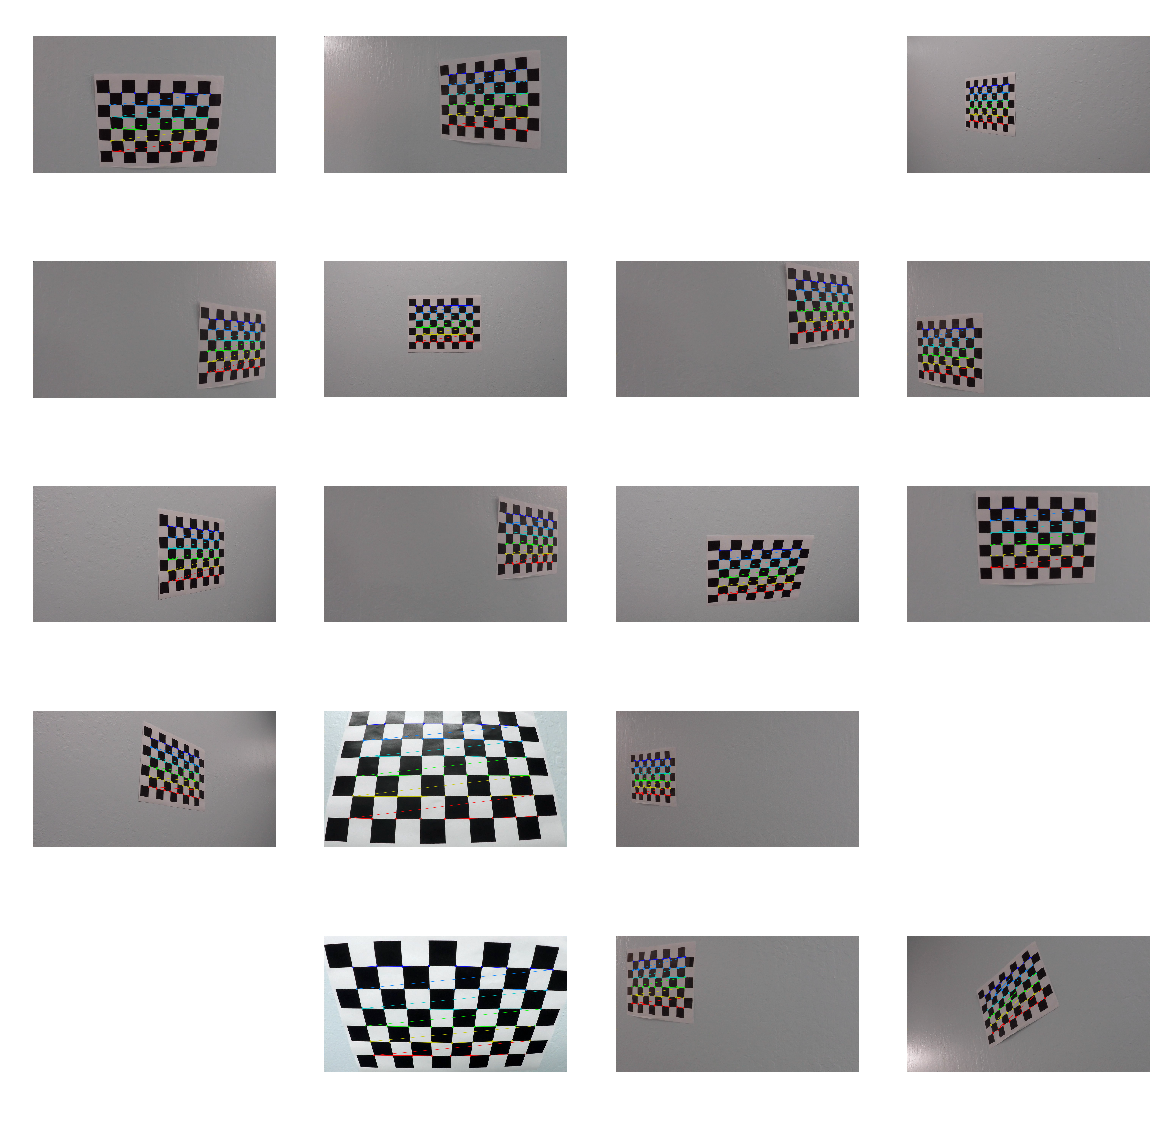

In [18]:
## Cell to call calibrate and save calibration data to a pickled file
mtx, dist = CalibrateCamera()

calibration_data = {} # Dictionary
calibration_data["mtx"] = mtx
calibration_data["dist"] = dist
pickle.dump(calibration_data, open("calibration.p","wb"))

In [3]:
## Cell to load camera calibration settings
def loadCalibrationSettings():
    calibration_data = {}
    with open("calibration.p",mode='rb') as f:
        calibration_data = pickle.load(f)
    mtx = calibration_data["mtx"]
    dist = calibration_data["dist"]
    return mtx,dist

In [4]:
def undistortImage(img, mtx, dist):
    image = cv2.undistort(img, mtx, dist, None, mtx)
    return image

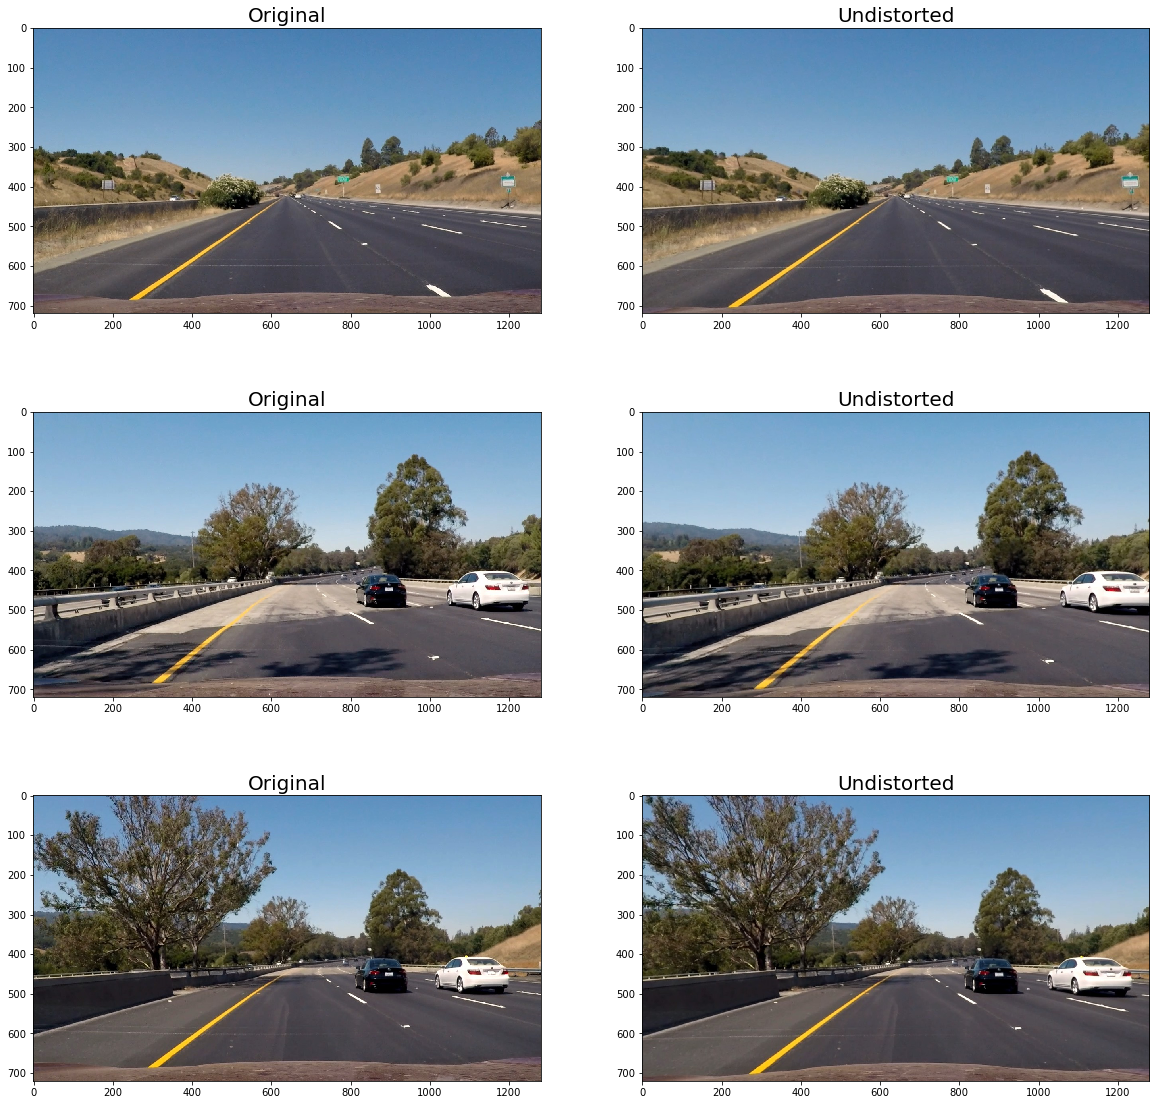

In [21]:
# Sample image undistortion check
ctr=0
plt.close('all')
nCol = 2 # 2 images per row
nRow = 3  # Need 11 rows for 43 classes
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)
#Have to get rid of rest of all the boundary axis
#for i in range((nCol*nRow)):
#    axis[i].axis('off')
mtx, dist = loadCalibrationSettings()

#First sample set
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)
axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(image)
ctr +=1
axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(img)
ctr +=1
mpimg.imsave('output_images/straight_lines1_undistorted', img)

#Second sample set
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)
axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(image)
ctr +=1
axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(img)
ctr+=1
mpimg.imsave('output_images/test4_undistorted', img)

#Second sample set
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)
axis[ctr].set_title('Original', fontsize=20)
axis[ctr].imshow(image)
ctr +=1
axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(img)
ctr+=1
mpimg.imsave('output_images/test6_undistorted', img)

In [33]:
## Cell for perspective transformation
def perspTransform(img, src, dst, imgSize):
    #Map points between undistorted and top-down perspective
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, imgSize, flags=cv2.INTER_LINEAR)
    return warped

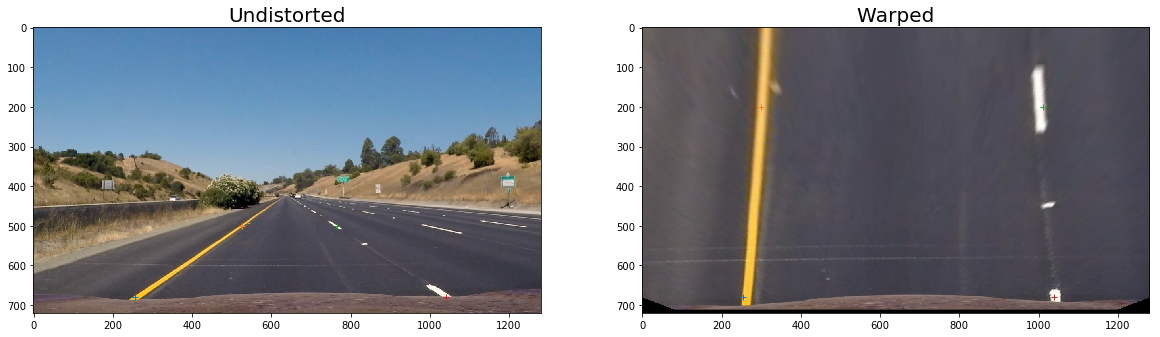

In [41]:
#Test for perspective transformation
ctr=0
plt.close('all')
nCol = 2 # 2 images per row
nRow = 1 # Need 1 row to display 2 images
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)

mtx, dist = loadCalibrationSettings()
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

#Experimental image sizes
src = np.float32( [ [255, 680],
                    [525, 500],
                    [765, 500],
                    [1040, 680] ]
                )

dst = np.float32( [ [255, 680],
                    [300, 200],
                    [1010, 200],
                    [1040, 680] ]
                )
imgSize = (img.shape[1], img.shape[0])

warped_img = perspTransform(img, src, dst, imgSize)

axis[ctr].set_title('Undistorted', fontsize=20)
axis[ctr].imshow(image)
axis[ctr].plot(255, 680, "+")
axis[ctr].plot(525, 500, "+")
axis[ctr].plot(765, 500, "+")
axis[ctr].plot(1040, 680, "+")
ctr +=1

axis[ctr].set_title('Warped', fontsize=20)
axis[ctr].imshow(warped_img)
axis[ctr].plot(255, 680, "+")
axis[ctr].plot(300, 200, "+")
axis[ctr].plot(1010, 200, "+")
axis[ctr].plot(1040, 680, "+")
ctr +=1


In [65]:
## Threshold functions cell
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if ( orient == 'x' ):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    
    # Apply threshold
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])]=1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Apply threshold
    # Rescale to 8 bit
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag)) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

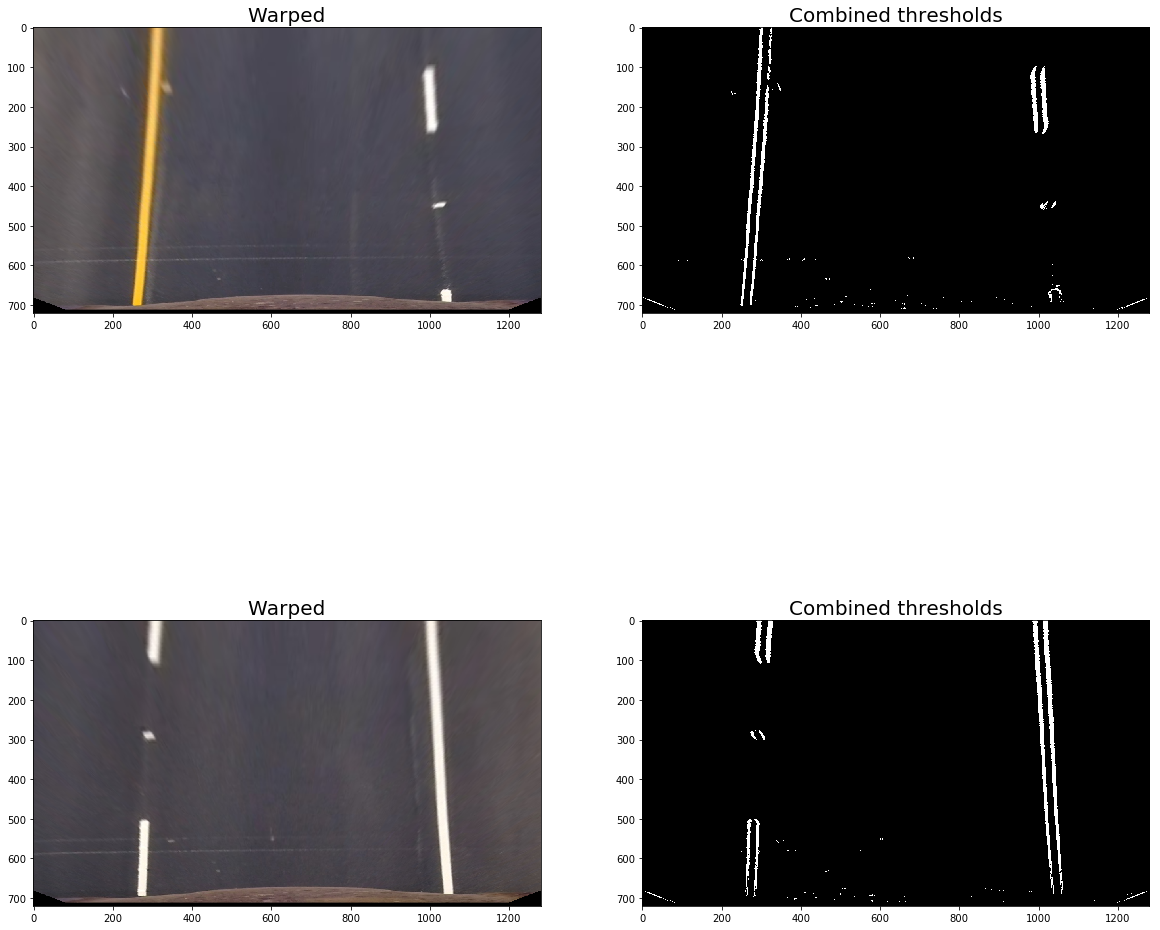

In [115]:
#Test for thresholding
ctr=0
plt.close('all')
nCol = 2 # 2 images per row
nRow = 2 # Need 1 row to display 2 images
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)
#Experimental image sizes
src = np.float32( [ [255, 680],
                    [525, 500],
                    [765, 500],
                    [1040, 680] ]
                )

dst = np.float32( [ [255, 680],
                    [300, 200],
                    [1010, 200],
                    [1040, 680] ]
                )
imgSize = (img.shape[1], img.shape[0])
mtx, dist = loadCalibrationSettings()

#imageset 1
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = undistortImage(image, mtx, dist)

warped_img = perspTransform(img, src, dst, imgSize)

axis[ctr].set_title('Warped', fontsize=20)
axis[ctr].imshow(warped_img, cmap='gray')
ctr +=1

grad_x     = abs_sobel_thresh(warped_img, orient='x', sobel_kernel=3, thresh=(30, 180))
grad_y     = abs_sobel_thresh(warped_img, orient='y', sobel_kernel=3, thresh=(30, 100))
mag_binary = mag_thresh(warped_img, sobel_kernel=3, mag_thresh=(30, 180))
dir_binary = dir_threshold(warped_img, sobel_kernel=3, thresh=(0.3, 1.3))

combined = np.zeros_like(mag_binary)
combined[(grad_x == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
axis[ctr].set_title('Combined thresholds', fontsize=20)
axis[ctr].imshow(combined, cmap='gray')
ctr +=1

#imageset 2
image_2 = cv2.imread('test_images/straight_lines2.jpg')
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
img_2 = undistortImage(image_2, mtx, dist)

warped_img_2 = perspTransform(img_2, src, dst, imgSize)

axis[ctr].set_title('Warped', fontsize=20)
axis[ctr].imshow(warped_img_2, cmap='gray')
ctr +=1

grad_x_2     = abs_sobel_thresh(warped_img_2, orient='x', sobel_kernel=3, thresh=(30, 180))
grad_y_2     = abs_sobel_thresh(warped_img_2, orient='y', sobel_kernel=3, thresh=(30, 100))
mag_binary_2 = mag_thresh(warped_img_2, sobel_kernel=3, mag_thresh=(30, 180))
dir_binary_2 = dir_threshold(warped_img_2, sobel_kernel=3, thresh=(0.3, 1.3))

combined_2 = np.zeros_like(mag_binary_2)
combined_2[(grad_x_2 == 1) | ((mag_binary_2 == 1) & (dir_binary_2 == 1))] = 1
axis[ctr].set_title('Combined thresholds', fontsize=20)
axis[ctr].imshow(combined_2, cmap='gray')
ctr +=1

##In above tests it was seen that grad_y is useless. Other than that the values were modified to get best lane detection